#                                 Document Clustering with Python

In [260]:
from bs4 import BeautifulSoup
from time import sleep
from random import randint
from time import time
from requests import get

# Randomly trying to crawl 4 pages having 200 movies for ease.
pages = [str(i) for i in range(5,9)]
years_url = [str(i) for i in range(2017,2018)]

names = []
years = []
imdb_ratings = []
genres = []
certificates = []
descriptions = []
gross = []

#Preparing the monitoring of the loop
start_time = time()
requests = 0

for year_url in years_url:

    # For every page of the interval
    for page in pages:
        print(page)
        
        # Make a get request
        request_url = ('http://www.imdb.com/search/title?release_date='+ year_url +'&sort=moviemeter,asc&page=' + page + '&ref_=adv_prv')
        print(request_url)
        response = get(request_url)

        # Pause the loop
        sleep(randint(8,15))
        
        # Monitor the requests
        requests += 1
        elapsed_time = time() - start_time
        print('Request:{}; Frequency: {} requests/s'.format(requests, requests/elapsed_time))
        #clear_output(wait = True)
        
        # Throw a warning for non-200 status codes
        if response.status_code != 200:
            warn('Request: {}; Status code: {}'.format(requests, response.status_code))
            
        # Break the loop if the number of requests is greater than expected
        if requests > 72:
            warn('Number of requests was greater than expected.')  
            break 
            
        # Parse the content of the request with BeautifulSoup
        page_html = BeautifulSoup(response.text, 'html.parser')
        
        # Select all the 50 movie containers from a single page
        mv_containers = page_html.find_all('div', class_ = 'lister-item mode-advanced')

        # For every movie of these 50
        for container in mv_containers:
            # If the movie has a Metascore, then:
            #if container.find('div', class_ = 'ratings-metascore') is not None:
                
                # Scrape the name
                name = container.h3.a.text
                names.append(name)
                
                # Scrape the year 
                year = container.h3.find('span', class_ = 'lister-item-year').text
                years.append((year))
                
               
                      
                #To get Gross
                raw_gross = container.find('span',attrs = {'class':'text-muted'})
                #find_next('span',attrs = {'name':'nv'})
                if raw_gross.text is not None and raw_gross.text == 'Gross:' :
                    raw_gross_1 = raw_gross.find_next('span',attrs = {'name':'nv'})
                    gross.append(raw_gross_1.text)
                else:
                    gross.append('') 
                
                
                #Certificate
                certificate = container.find('span',class_='certificate')
                if certificate is not None:
                    certificates.append(certificate.text)
                else:
                    certificates.append('')
                    
                # Scrape the description
                description1 = container.find('div',class_='ratings-bar')
                if description1 is not None:
                    description= description1.find_next('p',class_ = 'text-muted').text
                    descriptions.append(description.strip())
                else:
                    descriptions.append('')
                           
                
                # Scrape the genres
                genre_1 = container.find('span',class_ ='genre')
                if genre_1 is not None:
                    genres.append(genre_1.text.strip())
                else:
                    genres.append('')
    
                
                # Scrape the IMDB ratings
                #print(float(container.find('div',class_='inline-block ratings-imdb-rating')['data-value']))
                imdb_raw = container.find('div',class_='inline-block ratings-imdb-rating')
                if imdb_raw is not None:
                        imdb = float(container.strong.text)
                        imdb_ratings.append((imdb))
                    
                else:
                    imdb_ratings.append(0.0)
        

5
http://www.imdb.com/search/title?release_date=2017&sort=moviemeter,asc&page=5&ref_=adv_prv
Request:1; Frequency: 0.09851528449922443 requests/s
6
http://www.imdb.com/search/title?release_date=2017&sort=moviemeter,asc&page=6&ref_=adv_prv
Request:2; Frequency: 0.09240748624403639 requests/s
7
http://www.imdb.com/search/title?release_date=2017&sort=moviemeter,asc&page=7&ref_=adv_prv
Request:3; Frequency: 0.09651430804134029 requests/s
8
http://www.imdb.com/search/title?release_date=2017&sort=moviemeter,asc&page=8&ref_=adv_prv
Request:4; Frequency: 0.09808495980953721 requests/s


In [261]:
#Creating new array for titles and description.
titles=[]
synopses=[]

In [262]:
for name in names:
    titles.append(name)

In [263]:
for description in descriptions:
    synopses.append(description)

In [264]:
# Installation of all necessary libraries for analysis.
import numpy as np
import pandas as pd
import nltk
from bs4 import BeautifulSoup
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3

# Stopwords, stemming, and tokenizing

In [265]:
# IT shows the no. of each string.
print(str(len(titles)) + 'titles')
print(str(len(synopses)) + 'synopses')
print(str(len(genres)) + 'genres')

200titles
200synopses
200genres


In [266]:
# generates index for each item in the corpora.
ranks = []
for i in range(0,len(titles)):
    ranks.append(i)

In [267]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')

In [268]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [269]:
# here defined a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters.
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

Below I use my stemming/tokenizing and tokenizing functions to iterate over the list of synopses to create two vocabularies: one stemmed and one only tokenized. 

In [270]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in synopses:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

Using these lists, we created a pandas DataFrame with the stemmed vocabulary as the index and the tokenized words as the column. The benefit of this is it provides an efficient way to look up a stem and return a full token. s dl 

In [271]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)

In [272]:
vocab_frame

,words
on,on
coney,coney
island,island
in,in
the,the
1950s,1950s
a,a
lifeguard,lifeguard
tell,tells
the,the


## Tf-idf and document similarity

In [273]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=200000,
                                 stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopses)

print(tfidf_matrix.shape)

CPU times: user 168 ms, sys: 2.72 ms, total: 170 ms
Wall time: 169 ms
(200, 6774)


In [274]:
len(synopses)

200

In [275]:
terms = tfidf_vectorizer.get_feature_names()

In [277]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

# K-means clustering

Using the tf-idf matrix,I first chose k-means for analysis. For K-means we chose to create in 5 clusters. We tried with K having 2 and 3 but, results were not so accurate. So we chose to stick with 5.

In [278]:
from sklearn.cluster import KMeans
num_clusters = 5
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 148 ms, sys: 3.22 ms, total: 151 ms
Wall time: 150 ms


In [279]:
from sklearn.externals import joblib
clusters = km.labels_.tolist()

In [280]:
import pandas as pd

films = { 'synopses': synopses, 'ranks': ranks, 'cluster': clusters, 'genre': genres , 'title':titles }
frame = pd.DataFrame(films, index = [clusters] , columns = ['synopses', 'ranks', 'cluster', 'genre','title'])

In [301]:
frame

,synopses,ranks,cluster,genre,title
3,"On Coney Island in the 1950s, a lifeguard tell...",0,3,Drama,Wonder Wheel
0,An isolated community of superhumans fight to ...,1,0,"Action, Adventure, Sci-Fi",Inhumans
4,A young girl risks everything to prevent a pow...,2,4,"Action, Adventure, Drama",Okja
0,A small but brave donkey and his animal friend...,3,0,"Animation, Adventure, Comedy",The Star
2,An aspiring fashion designer struggles to find...,4,2,"Comedy, Drama",A Little Something for Your Birthday
0,A teenage girl and her little brother must sur...,5,0,"Horror, Thriller",Mom and Dad
0,"A single, 20-something mom struggles to find a...",6,0,Comedy,SMILF
0,"To protect his family, police detective Nikola...",7,0,Thriller,Grenseland
0,A shy small-town Ohio girl who loves movies bu...,8,0,"Adventure, Drama",In Search of Fellini
3,A two-hander action comedy in the vein of Midn...,9,3,"Action, Comedy",Just Getting Started


In [281]:
frame['cluster'].value_counts() # It shows the number of movies with each cluster.

0    102
3     39
2     23
4     21
1     15
Name: cluster, dtype: int64

In [282]:
grouped = frame['ranks'].groupby(frame['cluster']) # Here , we created counted mean for graphical representation.
grouped.mean()

cluster
0    107.431373
1     84.600000
2     92.782609
3     96.179487
4     85.142857
Name: ranks, dtype: float64

In [283]:
# It shows the top terms per cluster.
from __future__ import print_function

print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    for ind in order_centroids[i, :6]:
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print()
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.ix[i]['title'].values.tolist():
        print(' %s,' % titles, end='')
    print()
    print()

Top terms per cluster:

Cluster 0 words: b'woman', b'young', b'friend', b'lives', b'meeting', b'become',

Cluster 0 titles: ['Wonder Wheel', 'Inhumans', 'Okja', 'The Star', 'A Little Something for Your Birthday', 'Mom and Dad', 'SMILF', 'Grenseland', 'In Search of Fellini', 'Just Getting Started', 'Una mujer fantástica', 'Krystal', 'Atypical', 'Home Again', '1922', 'Icarus', 'Keeping Faith', 'Woody Woodpecker', 'Salvation', 'Loving Vincent', 'Cold Skin', 'Genius', 'The Tick', 'My Cousin Rachel', 'The LEGO Batman Movie', 'Stronger', 'Fifty Shades Darker', 'Jeepers Creepers 3', 'Inconceivable', 'Superior Donuts', 'Six', 'Lucky', 'Gone', 'Before I Fall', 'Newness', 'Lean on Pete', 'The Pirates of Somalia', 'Happy!', 'Snatched', 'Famous in Love', 'Keep Watching', 'The Disappearance', 'First Reformed', 'Papillon', 'The IMDb Show', 'The Forgiven', 'The Shack', 'Blue Planet II', 'Les affamés', 'CHIPS', "The Zookeeper's Wife", 'The Glass Castle', 'Descendants 2', 'Mary Kills People', 'Girlboss

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [284]:
#It export tables to html
frame['title'] = frame['title']
frame['genre'] = frame['genre']

# Multidimensional scaling

In [286]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [287]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

## Visualizing document clusters

In [316]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {0: 'young,friend,meeting',
                  1:'revenge,assassin,redemption',
                  2: 'life,women,crime', 
                  3: 'story,man,world', 
                  4: 'son,mother,kidnapping'
                }

In [317]:
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


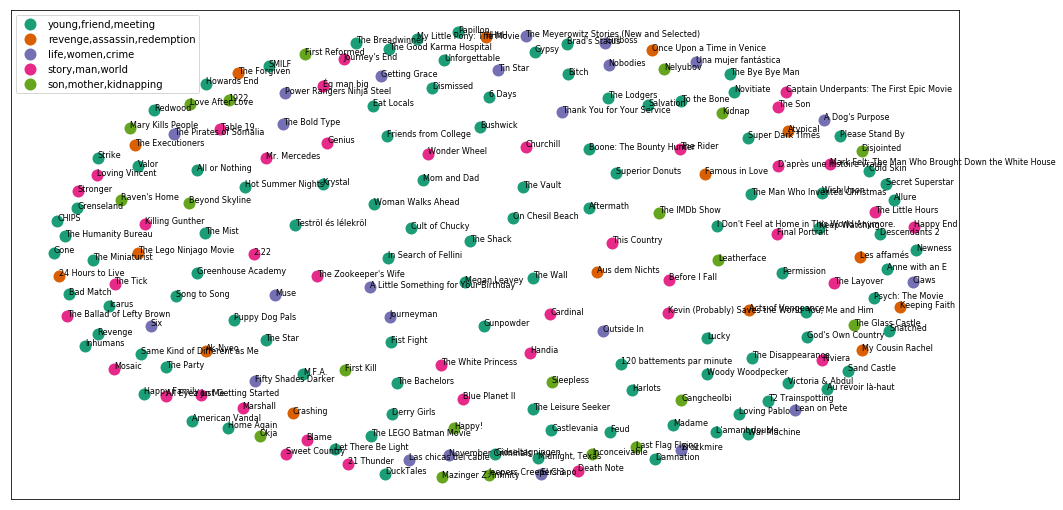

In [318]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  
plt.show() #show the plot
#plt.savefig('clusters_small_noaxes.png', dpi=200)

In [319]:
plt.close()

In [320]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [321]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = df.groupby('label')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }
"""

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    points = ax.plot(group.x, group.y, marker='o', linestyle='', ms=18, label=cluster_names[name], mec='none', color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot

#html = mpld3.fig_to_html(fig)
#print(html)

# Hierarchical document clustering

/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


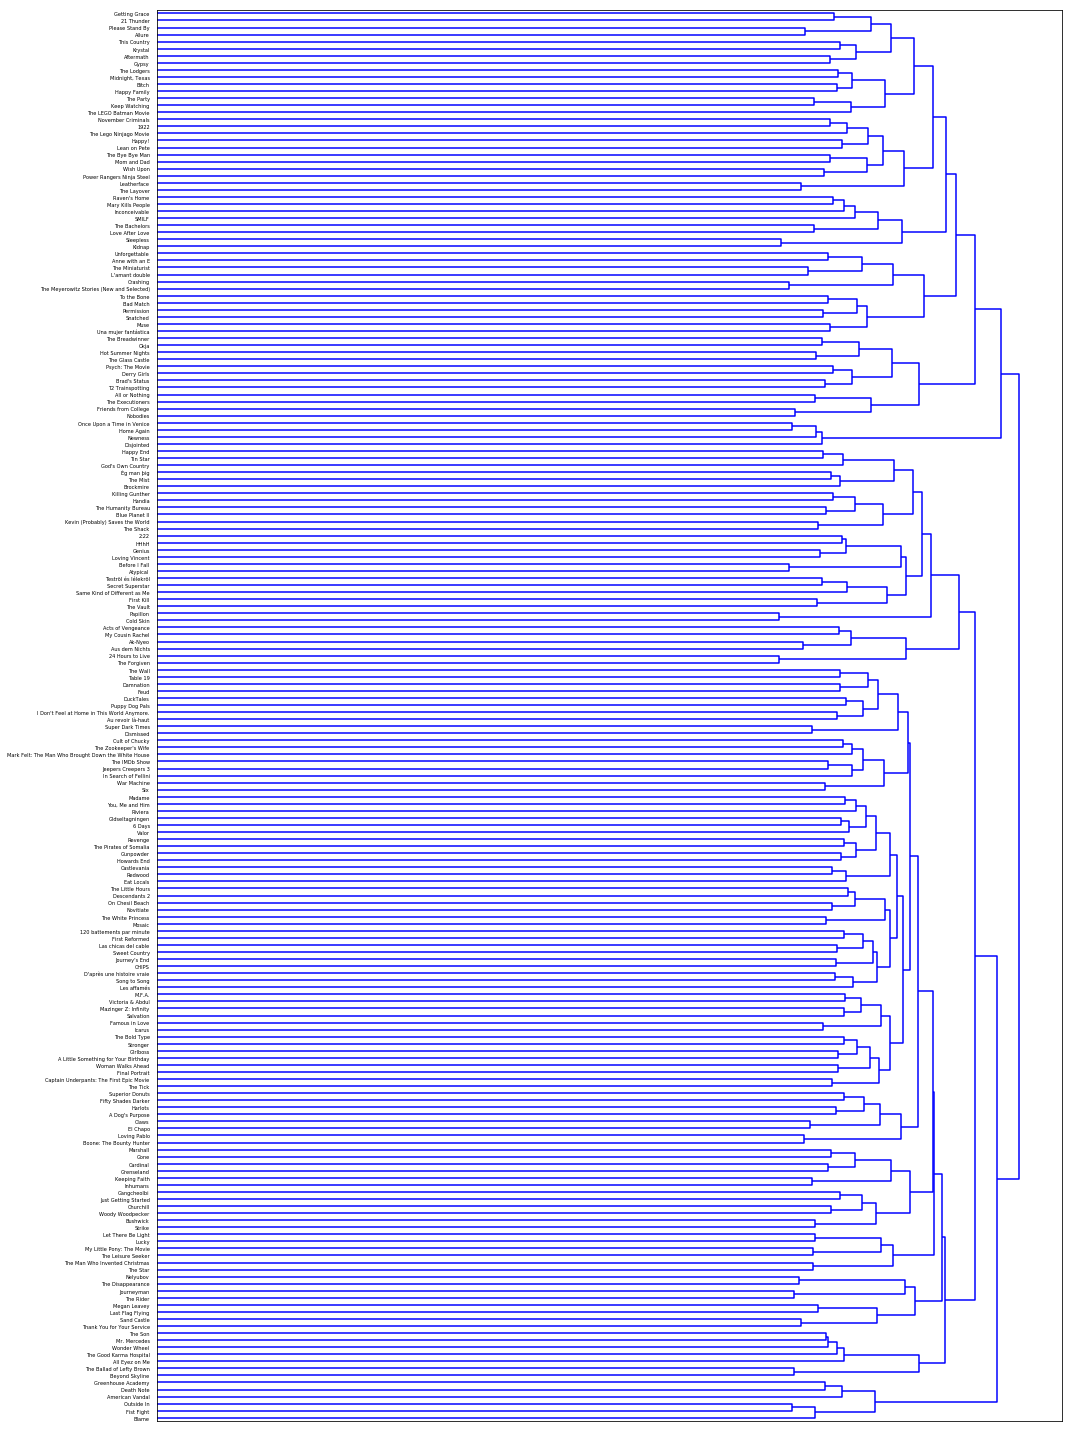

In [322]:
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=titles);

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with layout
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [324]:
plt.close()

# WordClouds

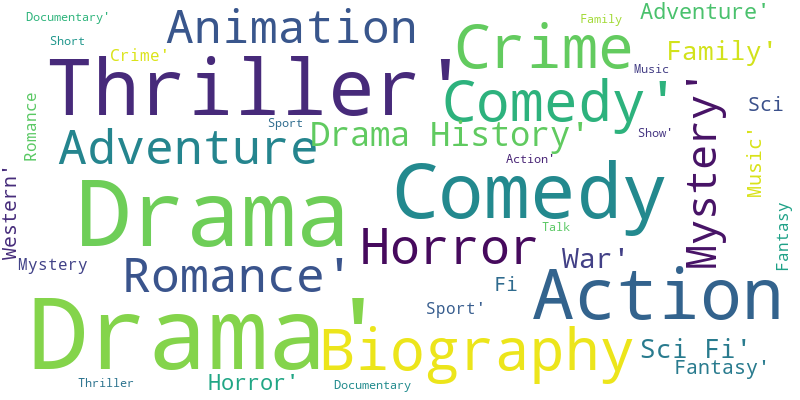

In [359]:
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# lower max_font_size
wordcloud = WordCloud(background_color='white',max_font_size=50, scale=2).generate(str(genres))
image = wordcloud.to_image()
image.show()
image

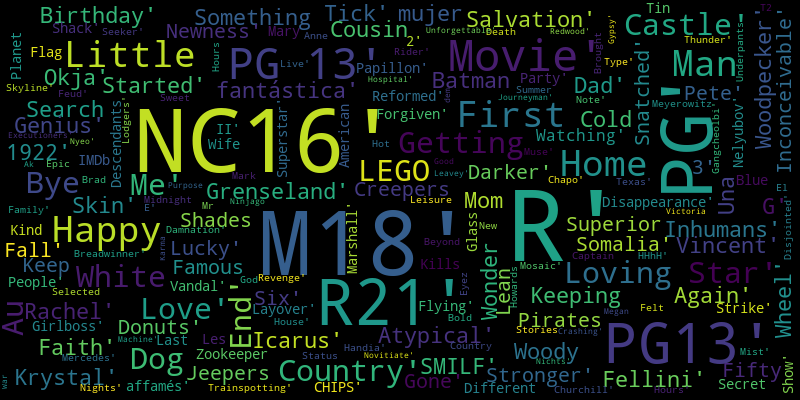

In [361]:
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# lower max_font_size
wordcloud = WordCloud(max_font_size=50, scale=2).generate(str(certificates) + str(titles))
image = wordcloud.to_image()
image.show()
image
#plt.figure()
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis("off")
#plt.show()